# Softmax Regression

by Linh Van Nguyen (contact@linhvannguyen.com)

as a part of the demonstration galeries for <a href="https://www.tensorflow.org/"> tensorflow </a>.

------------------------
This demo if following the tutorial on <a href="https://www.tensorflow.org/versions/0.6.0/tutorials/mnist/beginners/index.html"> Softmax Regression </a>. More informative tutorials on this subject can be found <a href="http://ufldl.stanford.edu/tutorial/"> at UFLDL tutorial</a>

Softmax Regression is the way we convert outcomes of a network model into probabilities. It contains two steps:

* accumulating evidences (including bias terms) through the network: says, at $i-$th layer, the accumulated evidence from the input $x$ is
$$evidence_i = \sum_jW_{i,j} x_j +b_i = W_ix+b_i$$
* converting into probability

$$y=softmax(evidence)$$

where $softmax(.)$ is defined as a normalization of the exponential of inputs:

$$softmax(x)=normalize(exp(x))$$

The normalization is to form a probability distribution of all inputs.

In [1]:
%matplotlib inline
import tensorflow as tf
import input_data # defined function to load data
import numpy as np
import matplotlib.pyplot as plt

## Import MINST data
This data contains 3 sets: training set (*mnist.train*) of 55000 samples, validation set (*mnist.validation*) of 5000 samples, and testing set (*mnist.test*) of 10000 samples. In each set, one sample contains an image of size 784 (28x28), a label of size 10 (all zeros except one).

Succesfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Succesfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Succesfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Succesfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(5000, 10)
10000


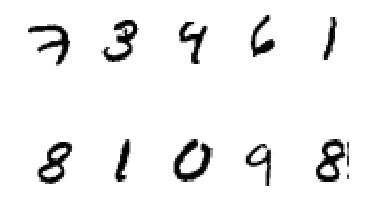

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
print np.shape(mnist.train.images)
print np.shape(mnist.validation.labels)
print mnist.test.num_examples

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.imshow(np.reshape(mnist.train.images[i],(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')

## Part 1: Simple network for regression

TensorFlow is built such that a graph of interacting operations is described and run entirely outside Python.Symbolic variables are used to describe such interacting operations. In this example, let define a symbolic variable, a 2-D tensor of floating-point numbers with shape $[None, 784]$ ($None$ means any dimension), to handle with the input image (in colum-liked form).

In [3]:
x = tf.placeholder(tf.float32, [None, 784])

To handle model's parameters (weights and biases), TensorFlow uses *Variable*, a modifiable tensor that lives in TensorFlow's graph of interacting operations. Here the network is defined to contain only one layer.

In [4]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

The sizes of the parameters should be consistent such that outputs of the network

$$y_i = softmax(Wx_i+b)$$

The model is then defined in tensorflow as:

In [5]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

Here the matrix multiplication is done by *tf.matmul*, where $x$ and $W$ are flipped to handle multiple images at the same time.

### Training

Define the cost function as the *cross-entropy*:

$$H_{y'}(y)=-\sum_i y_i' log(y_i)$$

where $y$ is the predicted probability distribution, and $y_i'$ is the true one. As an intepretation, the *cross-entropy* function measures how inefficient the predictions describe the truth. More about *cross-entropy* can be found <a href="http://colah.github.io/posts/2015-09-Visual-Information/"> here </a>. To implement the *cross-entropy* function, let define first a place holder to assign the predicted probabilities, then the *cross-entropy* $-\sum_i y_i' log(y_i)$

In [6]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

To train the model, tensorflow uses the <a href="http://colah.github.io/posts/2015-08-Backprop/">backpropagation algorithm </a> to determine the variables that minimize the cost you put in the model. Tensorflow then gives many  <a href="https://www.tensorflow.org/versions/0.6.0/api_docs/python/train.html#optimizers">optimization algorithms</a> to modify the variables and reduce the cost. For example, here *cross_entropy* cost function is monimized using the *gradient descent algorithm* with a learning rate of 0.01

In [7]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

Now once having the network structure, next step would be initializing the variable, lauch the model in a *Session* and run it with initial variables:

In [8]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

We will start training the model by iterating by *N_iter* steps using *stochastic gradient descent* optimization algorithm. *Stochastic* here is in a sense that each step takes a "batch" data points from the training set and pass them to the session via *feed_dict* function intead of the whole training data. The batch size is 100 in this example.

In [9]:
N_iter = 2000
for i in range(N_iter):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

### Evaluating the model

The accuracy of the trained network is evaluated as follows. Function *argmax* helps to find the correct label of each input, while *tf.equal* gives a list of boolean values to say whether the predictions match the reference label or not. Cast these boolean to 0 or 1, then taking the mean gives the accuracy of the network of the input data by *feed_dict* (this case is testing data)

In [10]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print "Accuracy for training data:", sess.run(accuracy, feed_dict={x: mnist.train.images, y_: mnist.train.labels})
print "Accuracy for testing data", sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

Accuracy for training data: 0.923436
Accuracy for testing data 0.9194


## Part 2: Multilayer Convolutional Network

The above network is very simple, and model's accuracy is rather unsatisfactory. We will build a convolutional network to improve it.

### Weight Initialization

We will create the following two handy function to initialize weights or bias of a given *shape*. Weights are initialized with a small mount of noises to break the symestry and prevent from zero-gradient. It is also suggested by tensorflow that bias should be slightly positive to avoid "dead" neurons.

Here function *tf.truncated_nomal(shape, mean = 0.0, stddev = 1.0)* returns random values follow a normal distribution of a give shape. *Truncated* here means values of magnitude more than 2 std are dropped and re-picked. *tf.constant (value, shape)* return constant *value* of given *shape*

In [11]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

### Convolution and Pooling

Define the two handy functions to convolve and pool features:

In [12]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### First Convolutional Layer

The first layer consists of convolution and followed by max pooling. The convolutional will compute 32 features for each 5x5 patch, and the weight tensor has a shape of [5, 5, 1, 32] accordingly (patch size 5x5, 1 input channel, 32 output channels. We will also have a bias vector with a component for each output channel.

After the first layer, an input image of size 28x28 after the convolution (zero padding) remains 28x28, max pooling by 2x2, will become an image of size 32x14x14.

In [13]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Second Convolutional Layer
The second layer has 64 features for each 5x5 patch. There are 32 input channels from the first layers, and 64 output channels. After this layer, we will have 64 features of size 7x7 for each 28x28 input image.

In [16]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### Densely Connected Layer

Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU

In [17]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#### Dropout
To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.


In [18]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout Layer

In [19]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

### Train and Evaluate the Model

In [20]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess=tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
for i in range(N_iter):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
    print "step %d, training accuracy %g"%(i, train_accuracy)
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print "test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, 
                                                                y_: mnist.test.labels, keep_prob: 1.0})

step 0, training accuracy 0.14
step 100, training accuracy 0.84
step 200, training accuracy 0.9
step 300, training accuracy 0.92
step 400, training accuracy 1
step 500, training accuracy 0.92
step 600, training accuracy 0.94
step 700, training accuracy 0.98
step 800, training accuracy 0.96
step 900, training accuracy 0.94
step 1000, training accuracy 0.98
step 1100, training accuracy 0.98
step 1200, training accuracy 0.96
step 1300, training accuracy 1
step 1400, training accuracy 0.98
step 1500, training accuracy 0.98
step 1600, training accuracy 0.98
step 1700, training accuracy 0.96
step 1800, training accuracy 0.98
step 1900, training accuracy 0.96
test accuracy 0.9762
